## **Regresión Logística y árboles de decisión (Decision Tree)**


Trabajaremos con los datos de entrenamiento de supervivencia del Titanic. Comenzaremos cargando los datos "train.csv".


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
titanic_train = pd.read_csv("train.csv")    # Leer los datos
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_train.shape
#titanic_train.dtypes

len(np.intersect1d(np.where(titanic_train["Sex"]=='male')[0], np.where(titanic_train["Survived"] == 1)[0]))



109

In [4]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
titanic_train["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Observe que el conteo de edad (714) es menor que el conteo total de filas del conjunto de datos (891). Esto indica que faltan datos. Podemos obtener los índices de las filas de los valores faltantes con np.where():

In [6]:
char_cabin = titanic_train["Cabin"].astype(str)     # Convertir "Cabin" a string

new_Cabin = np.array([cabin[0] for cabin in char_cabin]) # Toma la primea letra

titanic_train["Cabin"] = pd.Categorical(new_Cabin)  # Guarda la variable en "new_Cabin"

# Impute median Age for NA Age values
new_age_var = np.where(titanic_train["Age"].isnull(), # Logical check
                       28,                       # Value if check is true
                       titanic_train["Age"])     # Value if check is false

titanic_train["Age"] = new_age_var 

new_fare_var = np.where(titanic_train["Fare"].isnull(), 50, titanic_train["Fare"]) 
titanic_train["Fare"] = new_fare_var 

Hagamos un modelo de regresión logística que solo use la variable Sexo como predictor. Antes de crear un modelo con la variable sexo, debemos convertirlo a un número real porque las funciones de aprendizaje automático de sklearn solo tratan con números reales. Podemos convertir una variable categórica como en un número usando la función de preprocesamiento sklearn LabelEncoder():

In [7]:
from sklearn import linear_model
from sklearn import preprocessing

In [8]:
# Initialize label encoder
label_encoder = preprocessing.LabelEncoder()

# Convierte la variable Sex a numérica
encoded_sex = label_encoder.fit_transform(titanic_train["Sex"])

# Inicialize el modelo de regresión logística 
log_model = linear_model.LogisticRegression(solver = 'lbfgs')

# Entrena el modelo
log_model.fit(X = pd.DataFrame(encoded_sex),  y = titanic_train["Survived"])

# Verifica el intercepto y los coeficientes del modelo de entrenamiento
print(log_model.intercept_, log_model.coef_)

[1.01628767] [[-2.44597988]]


Los coeficientes del modelo de regresión logística se parecen al resultado que vimos para la regresión lineal. Podemos ver que el modelo produjo un valor de intercepción positivo y una ponderación de -2.421 en el género. Usemos el modelo para hacer predicciones en el conjunto de prueba:

In [9]:
# Hacemos las predicciones
preds = log_model.predict_proba(X= pd.DataFrame(encoded_sex))
preds = pd.DataFrame(preds)
preds.columns = ["Death_prob", "Survival_prob"]

# Genera una tabla de las predicciones vs Sexo
pd.crosstab(titanic_train["Sex"], preds.loc[:,"Survival_prob"])

Survival_prob,0.193147,0.734249
Sex,,
female,0,314
male,577,0


### <font color=red> **1. ¿Cómo interpreta los resultados de esta tabla?**

La tabla indica qué cantidad de hombres y de mujeres tienen cada una de las probabilidades de supervivencia. En este caso, todos los hombres tienen una probabilidad de supervivencia de 0.193 y las mujeres tienen 0.734 de probabilidad de sobrevivir. No hay ningún hombre con probabilidad mayor ni ninguna mujer con probabilidad menor que las indicadas, lo cual es de esperarse puesto que el modelo se generó apartir de solo la variable sexo.



Si generamos un modelo más complicado que incluya algunas variables más del conjunto de entrenamiento, tenemos:

In [10]:
# Convirtamos más variables a numéricas
encoded_class = label_encoder.fit_transform(titanic_train["Pclass"])
encoded_cabin = label_encoder.fit_transform(titanic_train["Cabin"])

train_features = pd.DataFrame([encoded_class, encoded_cabin, encoded_sex, titanic_train["Age"]]).T

# Initialize logistic regression model
log_model = linear_model.LogisticRegression(solver = 'lbfgs')

# Train the model
log_model.fit(X = train_features , y = titanic_train["Survived"])

# Intercepto y coeficientes del modelo
print(log_model.intercept_, log_model.coef_)

[3.85818122] [[-0.93272694 -0.09865307 -2.51826528 -0.03339524]]


A continuación, hagamos predicciones de clase usando este modelo y luego comparemos las predicciones con los valores reales:

In [11]:
# Hagamos las predicciones
preds = pd.DataFrame(log_model.predict(X= train_features))
preds.columns = ["Modelo"]

# Predicciones vs actual
pd.crosstab(preds["Modelo"],titanic_train["Survived"])

Survived,0,1
Modelo,,
0,458,89
1,91,253


Esta tabla indica la frecuencia de las distintas combinaciones de supervivencia y no supervivencia para los valores reales y los valores predichos por el modelo. Vemos que en total hay 180 datos para los cuales el modelo arroja un valor erróneo.

### <font color=red>**2. Genere la matriz de confusión y dibuje un mapa de calor**

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(titanic_train["Survived"], preds["Modelo"])
cm

array([[458,  91],
       [ 89, 253]])

Text(0.5, 15.0, 'Estado predicho')

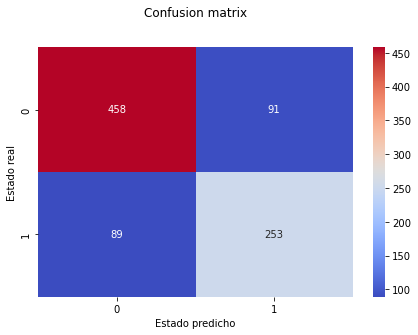

In [44]:
import seaborn as sns
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="coolwarm" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Estado real')
plt.xlabel('Estado predicho')

### <font color=red>**3. Calcule la precisión del modelo**

In [45]:
from sklearn.metrics import precision_score

print("La precisión del modelo es:",precision_score(titanic_train["Survived"], preds["Modelo"]))

La precisión del modelo es: 0.7354651162790697


### <font color=red>**4. Cree un modelo basado en el género de los pasajeros, pero esta vez usando árboles de decisión**

In [46]:
import numpy as np
import pandas as pd

In [47]:
# Load and prepare Titanic data
titanic_train = pd.read_csv("train.csv")    # Read the data

# Impute median Age for NA Age values
new_age_var = np.where(titanic_train["Age"].isnull(), 28,  titanic_train["Age"]) 
titanic_train["Age"] = new_age_var 

A continuación, necesitamos cargar e inicializar el modelo de árbol de decisión de scikit-learn y luego entrenar el modelo usando la variable sexo:

In [48]:
from sklearn import tree
from sklearn import preprocessing

In [49]:
# Initialize label encoder
label_encoder = preprocessing.LabelEncoder()

# Convert Sex variable to numeric
encoded_sex = label_encoder.fit_transform(titanic_train["Sex"])

# Inicializa el modelo
tree_model = tree.DecisionTreeClassifier()

# Entrena el modelo
tree_model.fit(X = pd.DataFrame(encoded_sex), y = titanic_train["Survived"])

DecisionTreeClassifier()

Ahora veamos una visualización del árbol que creó el modelo. Podemos hacer esto con la biblioteca `graphviz`:

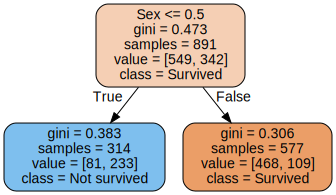

In [51]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree_model, feature_names=["Sex"] , out_file=None, class_names = ["Survived", "Not survived"] , rounded=True, filled=True) 
graph = graphviz.Source(dot_data)  
graph 

### <font color=red> **5. Cree un nuevo árbol de decisión que agregue la variable "Pclass" y muestre cómo cambian las predicciones resultantes**

In [61]:
# Inicializa el modelo
tree_bimodel = tree.DecisionTreeClassifier(max_depth=4)

# Entrena el modelo
tree_bimodel.fit(X = pd.DataFrame([encoded_sex, titanic_train["Pclass"]]).T, y = titanic_train["Survived"])

DecisionTreeClassifier(max_depth=4)

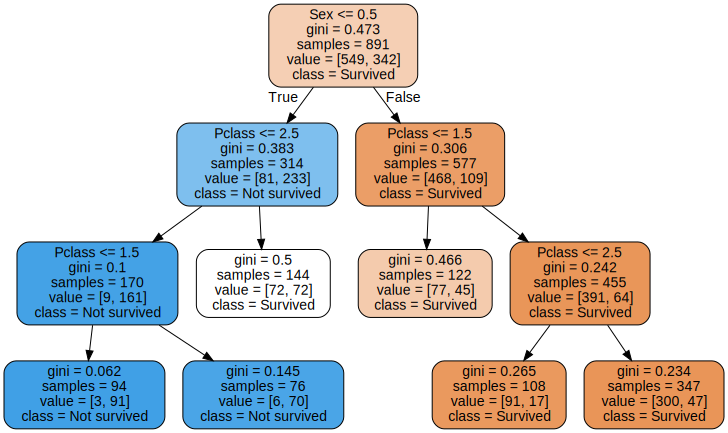

In [62]:
dot_bidata = export_graphviz(tree_bimodel, feature_names=["Sex", "Pclass"] , out_file=None, class_names = ["Survived", "Not survived"] , rounded=True, filled=True) 
graph = graphviz.Source(dot_bidata)  
graph 

### <font color=red> **6. Agregue una variable mas "Age" y muestre cómo cambian las predicciones resultantes**


In [70]:
# Inicializa el modelo
tree_trimodel = tree.DecisionTreeClassifier()

# Entrena el modelo
tree_trimodel.fit(X = pd.DataFrame([encoded_sex, titanic_train["Pclass"], titanic_train["Age"]]).T, y = titanic_train["Survived"])

DecisionTreeClassifier()

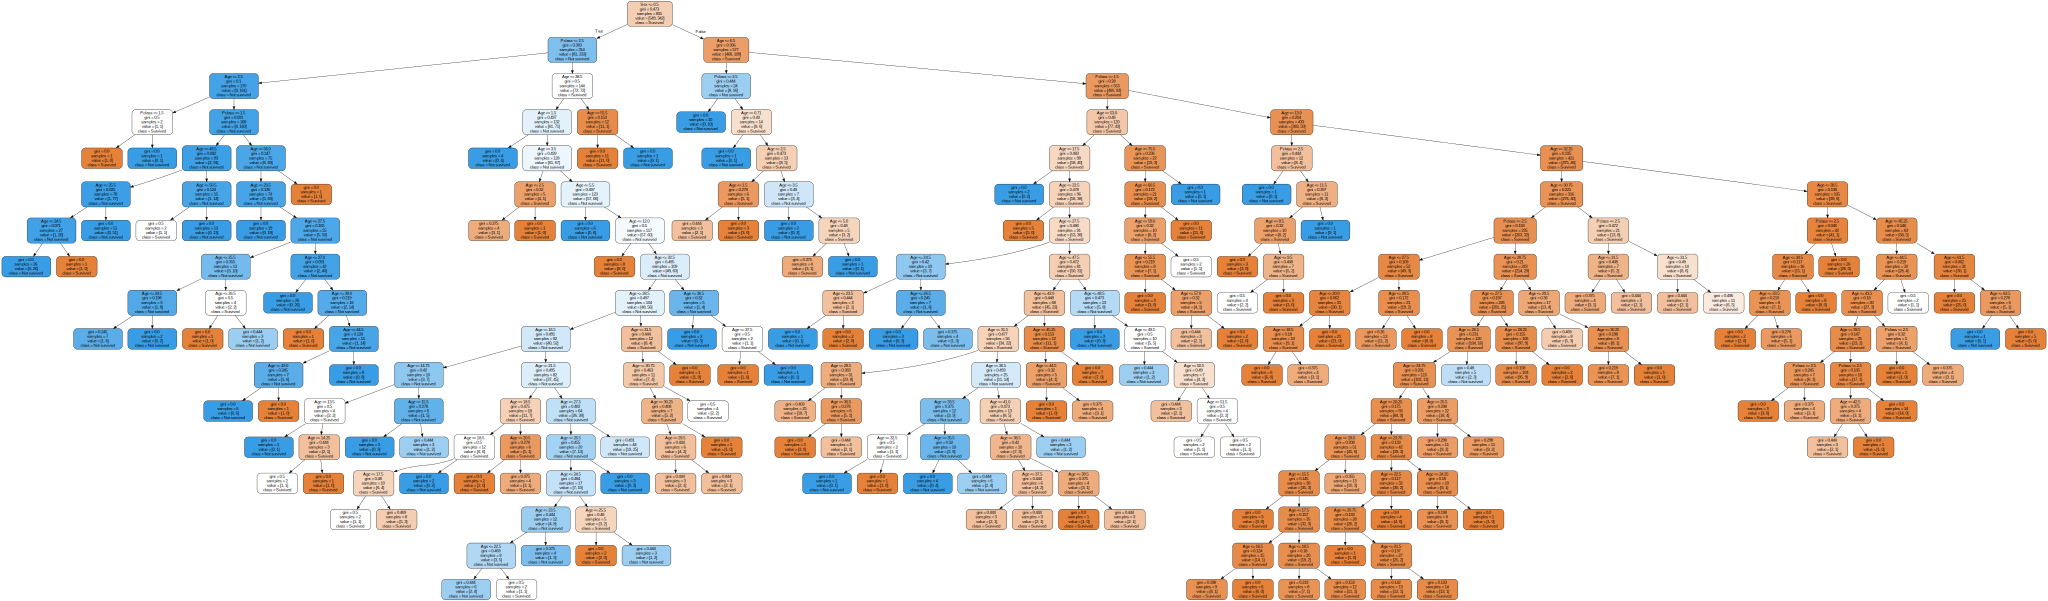

In [71]:
dot_tridata = export_graphviz(tree_trimodel, feature_names=["Sex", "Pclass", "Age"] , out_file= None, class_names = ["Survived", "Not survived"] , rounded=True, filled=True) 
graph = graphviz.Source(dot_tridata)  
graph 

In [78]:
from graphviz import Source

# Se adjunta la imagen del árbol para mejor visualización.

grafico = Source(dot_tridata)
grafico.format = 'pdf'
grafico.render('tree_titanic', view = False)


'tree_titanic.pdf'

¿Cuál es la precisión de este modelo (decision Tree) en los datos de entrenamiento?

In [82]:
Y_pred = tree_trimodel.predict(pd.DataFrame([encoded_sex, titanic_train["Pclass"], titanic_train["Age"]]).T)

print("La precisión del modelo es:",precision_score(titanic_train["Survived"], Y_pred))

La precisión del modelo es: 0.8896321070234113
